<img align="center" src="http://sydney.edu.au/images/content/about/logo-mono.jpg">
<h1 align="center" style="margin-top:10px">Statistical Learning and Data Mining</h1>
<h2 align="center" style="margin-top:20px">Week 8 Tutorial: Generalised Additive Models</h2>
<br>

In this notebook, we study how to train regression splines and generalised additive models using Python.

<a class="buttom" href="#1.-Customer-analytics-data">Customer analytics data</a> <br>
<a class="buttom" href="#2.-Some-EDA">Some EDA</a> <br>
<a class="buttom" href="#3.-Regression-Splines">Regression Splines</a> <br>
<a class="buttom" href="#4.-Generalised-additive-model">Generalised additive model</a> <br>
<a class="buttom" href="#5.-Explainable-boosting-machine">Explainable boosting machine</a> <br>
<a class="buttom" href="#6.-Model-selection">Model selection</a> <br>

This notebook relies on the following imports and settings.

In [35]:
# Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [36]:
# Plot settings
sns.set_context('notebook') # optimises figures for notebook display
sns.set_style('ticks') # set default plot style
colours = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', 
           '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']
sns.set_palette(colours) # set custom color scheme
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# 1. Customer Analytics Data 

The dataset for this tutorial is from customer analytics.  A key task in customer analytics is to predict the profitability of a customer, which involves both classification and regression tasks. We can apply classification methods to predict whether a customer will be acquired and retained, and regression methods to estimate the profitability of acquired and retained customers.

We focus on the regression task, though a more complete model can include all parts of the customer cycle. We will predict the customer lifetime value (CLV, a measure of profitability), taking into account some of the nonlinearities in the data.

The data is from a company that does business-to-business (B2B) sales. 

In [38]:
data = pd.read_excel('CustomerAcquisition.xls', index_col=[0])
data.head(10)

,Acquisition,First_Purchase,CLV,Duration,Censor,Acq_Expense,Acq_Expense_SQ,Industry,Revenue,Employees,Ret_Expense,Ret_Expense_SQ,Crossbuy,Frequency,Frequency_SQ
Customer,,,,,,,,,,,,,,,
1,1,433.64,0.0000,384,0,760.36,578147.33,1,30.16,1240,2309.79,5335129.84,5,2,4
2,0,0.00,0.0000,0,0,147.70,21815.29,1,39.80,166,0.00,0.00,0,0,0
3,0,0.00,0.0000,0,0,252.56,63786.55,1,54.93,1016,0.00,0.00,0,0,0
4,1,225.84,5.7316,730,1,609.73,371770.67,1,45.83,122,2192.59,4807450.91,2,12,144
5,1,363.04,0.0000,579,0,672.36,452067.97,1,69.03,313,801.14,641825.30,4,7,49
6,0,0.00,0.0000,0,0,435.57,189721.22,0,22.54,359,0.00,0.00,0,0,0
7,0,0.00,0.0000,0,0,362.90,131696.41,0,32.97,902,0.00,0.00,0,0,0
8,0,0.00,0.0000,0,0,883.54,780642.93,0,22.48,264,0.00,0.00,0,0,0
9,1,599.30,6.9161,730,1,452.35,204620.52,1,17.98,1782,1340.75,1797610.56,1,11,121



The response variable is thus the CLV of customers who were acquired and remained as customers by the end of the observation window (730 days). These customers are identified with a value of one for the `Censor` variable.

In [39]:
data = data[data['Censor']==1] # our goal is to predict the CLV of retained customers, identified by Censor=1 

The predictors are dollars spent on acquiring and retaining the client, the value of the first purchase, revenue and number of employees of the client, the number of product categories which the customer purchased, the number of purchase occasions, and the industry the client belongs to.

In [40]:
response = ['CLV']

continuous = ['Acq_Expense', 'Ret_Expense', 'First_Purchase', 'Revenue', 'Employees']
discrete = ['Frequency', 'Crossbuy']
binary = ['Industry']

predictors = continuous + discrete + binary
    
data = data[response + predictors] # keeping only the variables that we are going to use

We split the data into training (70%) and validation (30%) sets before proceeding. 

In [41]:
from sklearn.model_selection import train_test_split

# Randomly split indexes
index_train, index_valid = train_test_split(np.array(data.index), train_size=0.7, random_state=1)

# Write training and validation sets 
train = data.loc[index_train,:].copy()
valid = data.loc[index_valid,:].copy()

y_train = train['CLV'].to_numpy()
y_valid = valid['CLV'].to_numpy()

It will be useful to standardise the numerical features.

In [42]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train.loc[:, continuous + discrete] = scaler.fit_transform(train.loc[:, continuous + discrete])
valid.loc[:, continuous + discrete] = scaler.transform(valid.loc[:, continuous + discrete])

X_train = train[predictors]
X_valid = valid[predictors]

# 2. Some EDA

We relied on automated EDA many times in previous tutorials. These are great tools that can save you time, but as you get more programming experience, I suggest that you also start developing your own personal library of EDA functions.  You can then customise all the tables and plots according to your needs and export the results to include in a presentation or report. Further, automated EDA may struggle with large datasets.

Therefore, this is the approach that we will follow today. Below, we code a function to visualise the relationship between the response and each of the inputs. It would probably be better to skip ahead to see the desired result, and then go back to understand the code.  

In [9]:
def plotregressions(X, y, lowess=False):
    # X should be a pandas dataframe
    
    colours = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', 
               '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']

    # Feature names
    labels = list(X.columns)
    
    n, p = X.shape
    
    # We want three plots per column, calculate the required number of rows accordingly
    rows = int(np.ceil(p/3)) 
    
    # Create a plot grid
    fig, axes = plt.subplots(rows, 3, figsize=(12, rows*(12/4)))

    # Loop over the plot grid, create 
    for i, ax in enumerate(fig.axes):
        if i < p:
            
            # Scatter plot with local smoothing
            sns.regplot(X.iloc[:, i], y,  ci=None, y_jitter=0.05, 
                        scatter_kws={'s': 25, 'alpha':.8}, ax=ax, lowess=lowess, color=colours[i % 10])
            
            # Remove axis labels to de-clutter the plot
            ax.set_xlabel('')
            ax.set_ylabel('')
            
            # Manually set the limits for the horizontal axis since the default doesn't work so well
            xmin = X.iloc[:,i].min()
            xmax = X.iloc[:,i].max()
            ax.set_xlim(xmin - (xmax-xmin)*0.05, xmax + (xmax - xmin)*0.05)
            
            # Use the feature name for the title
            ax.set_title(labels[i])
        else:
            # Delete unnecessary subplot (last row)
            fig.delaxes(ax)

    sns.despine()
    plt.tight_layout()
    
    return fig, axes

There seems to be some nonlinearity in the data, especially in the case of the retention expense.

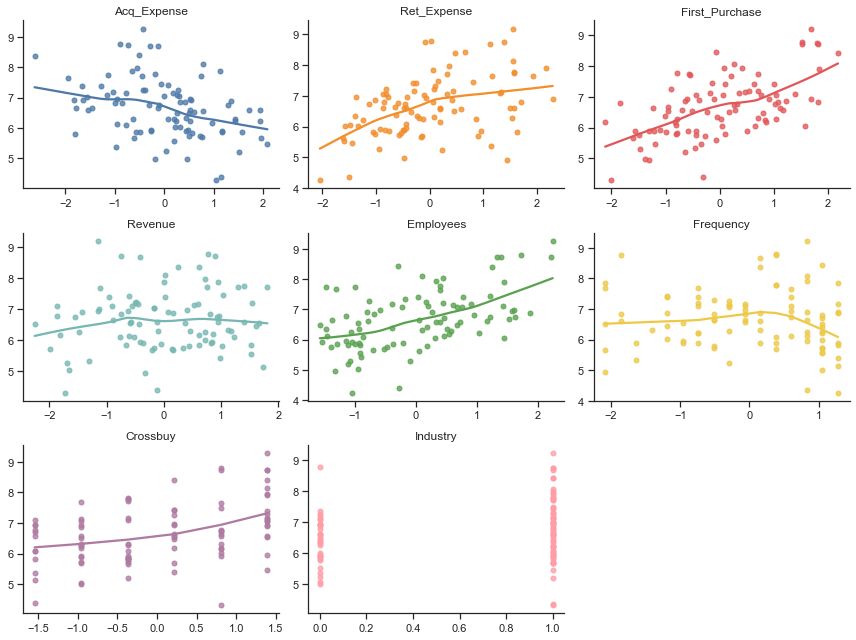

In [10]:
plotregressions(train[predictors], y_train, lowess=True)
plt.show()

# 3. Regression Splines

In this section, we'll focus on a single predictor to study regression splines.

## 3.1 Constructing spline representations

We can use the [<TT>patsy</TT>](http://patsy.readthedocs.io/en/latest/index.html) library to obtain the basis expansions for the regression splines. Our implementation is based on two core functions: [<TT>dmatrix</TT>](http://patsy.readthedocs.io/en/latest/API-reference.html#patsy.dmatrix), the general design matrix constructor, and [<TT>bs</TT>](http://patsy.readthedocs.io/en/latest/API-reference.html#spline-regression), the building block for regression splines.

The next cell builds cubic spline basis expansions for retention expenses variable. We specify that we want the cubic spline by setting `degree=3`. We remove the column of ones from the design matrix because the intercept will be added later.  We set the degrees of freedom as `df=4`, which corresponds to one knot (recall from the lecture that when the intercept is not included, the degrees of fredom is the number of knots plus 3; this is how the package interprets the requested degrees of freedom).

The function below uses basis functions called B-splines, rather than the exact spline functions defined in the lecture. B-splines generate an equivalent model but have favourable numerical properties. 

$$\large \beta_0 + \beta_1 x + \beta_2 x^2 + \beta_3 x^3 + \beta_4(x - \xi_1)^3_+$$

In [43]:
from patsy import dmatrix

# The -1 excludes the intercept
X = dmatrix('bs(predictor, degree=3, df=4) - 1', {'predictor': train['Ret_Expense']}, return_type='dataframe')

Given the design matrix, we estimate the model by OLS. 

In [44]:
ols = LinearRegression()
ols.fit(X, y_train)

LinearRegression()

We now plot the estimated model. To do this, we need to generate a grid of values for the feature and create the corresponding design matrix. 

In [47]:
from patsy import build_design_matrices

# Create a grid of values for the feature
xmin = train['Ret_Expense'].min()
xmax = train['Ret_Expense'].max()
x = np.linspace(xmin, xmax)

# remember that X is our original design matrix
XX = build_design_matrices([X.design_info], {'predictor': x})[0] 
y_fitted = ols.predict(XX)

Finally, we plot the regression fit. 

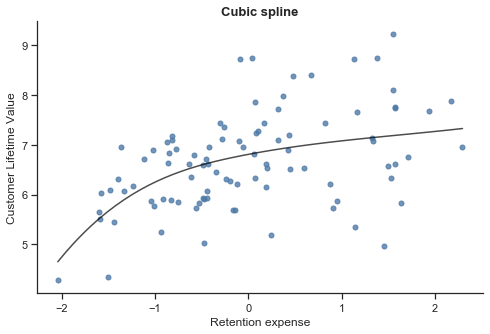

In [48]:
# Intialise figure
fig, ax = plt.subplots(figsize=(8,5))

# Scatter plot
sns.regplot(train['Ret_Expense'], y_train,  scatter_kws = {'s': 25}, fit_reg=False)

# Plot regression spline
ax.plot(x, y_fitted, color='Black', alpha=0.7)

# Plot labels
ax.set_xlabel('Retention expense')
ax.set_ylabel('Customer Lifetime Value')
ax.set_title('Cubic spline', fontsize=13, fontweight='bold')

sns.despine()
plt.show()

The next cell repeats all these steps for a linear spline with two knots. You should experiment by changing the first two lines to try different models (say, by adding more knots and/or changing the polynomial degree) and trying different predictors.

In [15]:
predictors

['Acq_Expense',
 'Ret_Expense',
 'First_Purchase',
 'Revenue',
 'Employees',
 'Frequency',
 'Crossbuy',
 'Industry']

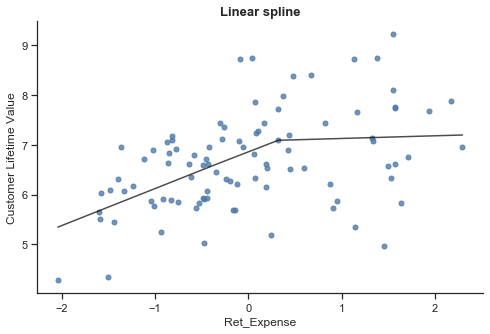

In [58]:
predictor = 'Ret_Expense'
X = dmatrix('bs(variable, degree=1, df=3) - 1', {'variable': train[predictor]}, return_type='dataframe')

ols = LinearRegression()
ols.fit(X, y_train)

xmin = train[predictor].min()
xmax = train[predictor].max()
x = np.linspace(xmin, xmax, 1000)

XX = build_design_matrices([X.design_info], {'variable': x})[0]
y_fitted = ols.predict(XX)

fig, ax = plt.subplots(figsize=(8,5))
sns.regplot(train[predictor], y_train,  scatter_kws = {'s': 25}, fit_reg=False)
ax.plot(x, y_fitted, color='Black', alpha=0.7)
ax.set_ylabel('Customer Lifetime Value')
ax.set_title('Linear spline', fontsize=13, fontweight='bold')

sns.despine()
plt.show()

## 3.2 Natural splines

Estimating a natural cubic spline requires only a minor modification in the code.

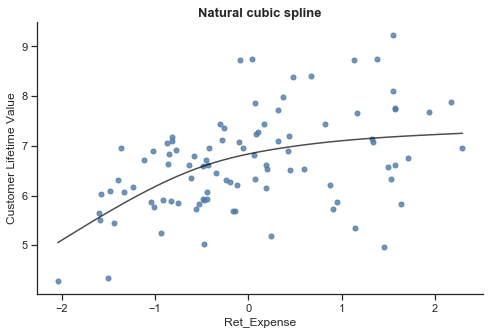

In [59]:
predictor = 'Ret_Expense'
X = dmatrix('cr(variable, df=4) - 1', {'variable': train[predictor]}, return_type='dataframe')

ols = LinearRegression()
ols.fit(X, y_train)

xmin = train[predictor].min()
xmax = train[predictor].max()
x = np.linspace(xmin, xmax)

XX = build_design_matrices([X.design_info], {'variable': x})[0] 
y_fitted = ols.predict(XX)

fig, ax = plt.subplots(figsize=(8,5))
sns.regplot(train[predictor], y_train,  scatter_kws = {'s': 25}, fit_reg=False)
ax.plot(x, y_fitted, color='Black', alpha=0.7)
ax.set_ylabel('Customer Lifetime Value')
ax.set_title('Natural cubic spline', fontsize=13, fontweight='bold')

sns.despine()
plt.show()

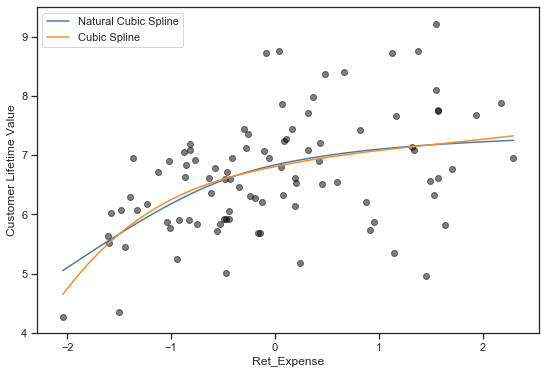

In [68]:
predictor = 'Ret_Expense'

xmin = train[predictor].min()
xmax = train[predictor].max()
e = 0
x = np.linspace(xmin - e, xmax + e)


# Natural Spline
X = dmatrix('cr(variable, df=4) - 1', {'variable': train[predictor]}, return_type='dataframe')
ols = LinearRegression()
ols.fit(X, y_train)

XX = build_design_matrices([X.design_info], {'variable': x})[0] 
natural_cubic_spline_predictions = ols.predict(XX)


# Cubic Spline
X = dmatrix('bs(predictor, degree=3, df=4) - 1', {'predictor': train[predictor]}, return_type='dataframe')
ols = LinearRegression()
ols.fit(X, y_train)

XX = build_design_matrices([X.design_info], {'predictor': x})[0]
cubic_spline_predictions = ols.predict(XX)



# Plots
plt.plot(x, natural_cubic_spline_predictions, label='Natural Cubic Spline')
plt.plot(x, cubic_spline_predictions, label='Cubic Spline')
plt.scatter(train[predictor], y_train, color='black', alpha=0.5)

plt.xlabel(predictor)
plt.ylabel('Customer Lifetime Value')

plt.legend();

# 4. Generalised Additive Model


We use [pyGAM](https://pygam.readthedocs.io/en/latest/) to build a generalised additive model. 

This package follows an approach between smoothing splines and regression splines to fit the functions.  Like a smoothing spline, it uses a form of $\ell_2$ regularisation to penalise the roughness of the function. However, it uses a specified number of knots for the representation, like a regression spline. This is because having a knot for each data point, as in a smoothing spline, is computationally expensive and usually unnecessary.  

The next cell illustrates the syntax In pyGAM, `s` specifies a spline term, `l` a linear term, `f` a factor term (this corresponds to one-hot encoding of a discrete variable), and `te` a tensor product (an interaction term). 

Below, `s(0)` means that we model the first predictor (acquisition expense) using a spline term. `s(1, constraints='monotonic_inc')` means that we model the second predictor using a spline term constrained to be increasing (the value of the function can only increase if we increase the input).  You can also constrain the function to be decreasing, concave, or convex. `te(2, 3)` specifies an interaction between the third and fourth predictors.  

https://pygam.readthedocs.io/en/latest/notebooks/tour_of_pygam.html

https://pygam.readthedocs.io/en/latest/notebooks/tour_of_pygam.html#Penalties-/-Constraints

In [32]:
X_train.head()

,Acq_Expense,Ret_Expense,First_Purchase,Revenue,Employees,Frequency,Crossbuy,Industry
Customer,,,,,,,,
350,0.026731,-0.941970,-1.468372,-1.692956,-1.079390,-0.291015,-0.369002,1
317,0.271786,0.082344,0.699330,1.544606,0.160913,-0.291015,0.218900,1
337,-0.423261,0.434920,0.533899,-0.509739,0.899188,-0.739463,1.394704,0
467,-0.982885,1.146038,-0.457309,-1.310067,-0.098960,-1.636360,-1.544806,0
184,0.776435,1.553852,0.254340,0.010786,0.095944,0.830107,1.394704,1


In [60]:
from pygam import LinearGAM, s, f, l, te

gam = LinearGAM(s(0) + s(1, constraints='monotonic_inc') + te(2, 3) + s(4) + s(5) + f(6) + l(7))

In pyGAM, there's a different regularisation hyperparameter for each term. We need to set the penalties appropriately for this approach to make sense. 

We use Optuna for Bayesian hyperparameter optimisation. 

Two important details:

* We only use splines for the first two predictors (acquisition expense and retention expense). Using splines for the other predictors would cause overfitting.

* The model selection criterion is the generalised cross-validation (GCV) score. This is an analytical approximation to leave-one-out cross-validation that applies to this type of model. 

Running the optimisation for a couple of minutes should be enough to find a good configuration in this case. Note that Optuna makes your CPU work hard. In the assignment, you'd probably want to do this on Google Colab or another cloud service. 

In [ ]:
import optuna
from optuna.samplers import TPESampler

def objective(trial):

    lambdas = []
    for j in range(len(predictors)):
        lambdas.append(trial.suggest_loguniform(f'lambda_{j}', 1e-4, 10000.0))
                               
    model = LinearGAM(s(0) + s(1) + l(2) + l(3) + l(4) + l(5) + l(6) + l(7), lam = lambdas)
    model.fit(X_train, y_train)
    
    return model.statistics_['GCV']

sampler = TPESampler(seed=42)  # makes the sampler behave in a deterministic way
study = optuna.create_study(direction='minimize', sampler=sampler) # TPE is a method for Bayesian optimisation
study.optimize(objective, n_trials=10000, timeout=120) 

This approach is only viable when the number of features is low. When there are more predictors, we usually use the same penalty for all linear terms (identically to a ridge regression) and optimise the hyperparameters one-by-one by cycling through the predictors (similary to backfitting, but for hyperparameter optimisation).

After using Optuna, you need to train the model again with the best hyperparameters. 

In [61]:
best_params_values = [168.00299559276223, 94.72928664281234, 0.045656415074922456, 27.286792022602636,
                      2678.2292116138783, 0.0002584830805100755, 2.080542918945382, 0.004738850362826395]

In [62]:
# lambdas = list(study.best_params.values())
lambdas = best_params_values

gam = LinearGAM(s(0) + s(1) + l(2) + l(3) + l(4) + l(5) + l(6) + l(7), lam=lambdas)
gam.fit(X_train, y_train)

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, 
   terms=s(0) + s(1) + l(2) + l(3) + l(4) + l(5) + l(6) + l(7) + intercept,
   tol=0.0001, verbose=False)

`pyGAM` provides a convenient model summary. It's especially useful to check the degrees of freedom used by each spline.

https://pygam.readthedocs.io/en/latest/notebooks/quick_start.html?highlight=lambda#Automatically-tune-the-model

In [63]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     10.7017
Link Function:                     IdentityLink Log Likelihood:                                   -202.209
Number of Samples:                           94 AIC:                                              427.8216
                                                AICc:                                             431.4781
                                                GCV:                                                0.1729
                                                Scale:                                              0.1379
                                                Pseudo R-Squared:                                    0.869
Feature Function                  Lam

The following code from the [pyGAM documentation](https://pygam.readthedocs.io/en/latest/notebooks/quick_start.html#Partial-Dependence-Functions) allows us to plot the partial dependence functions.

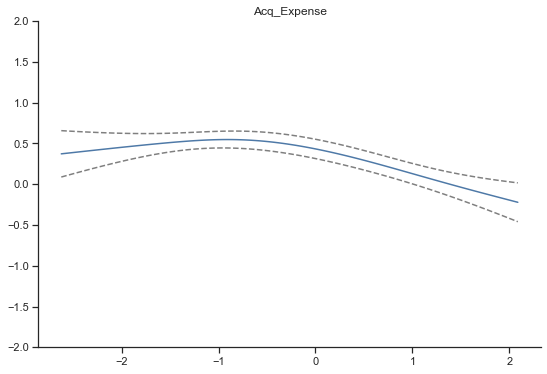

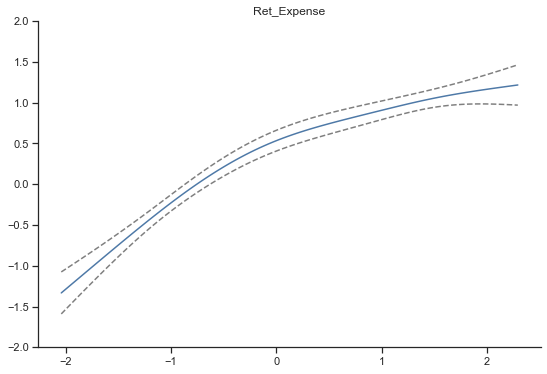

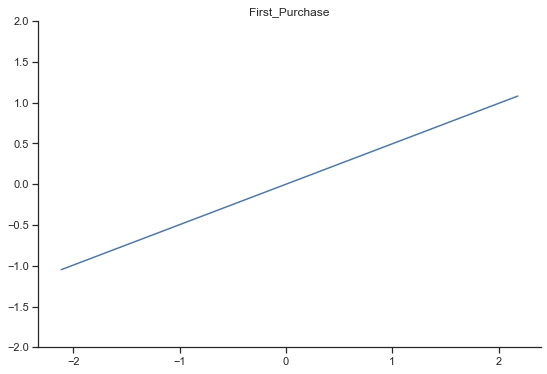

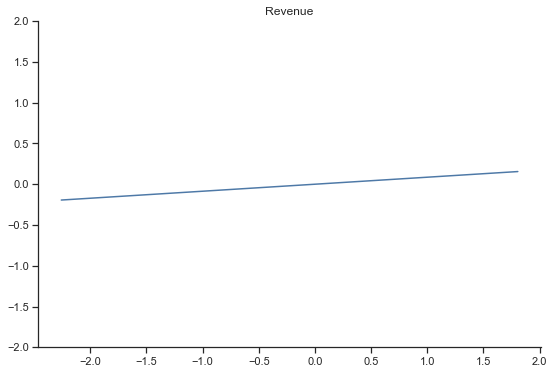

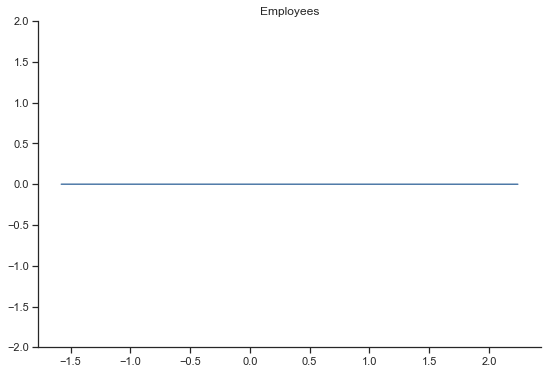

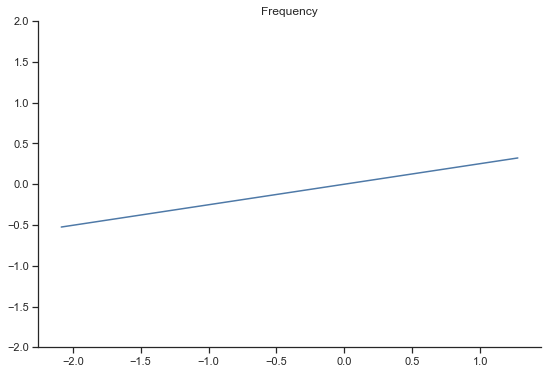

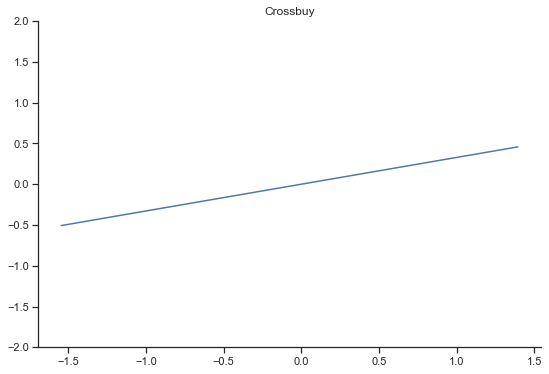

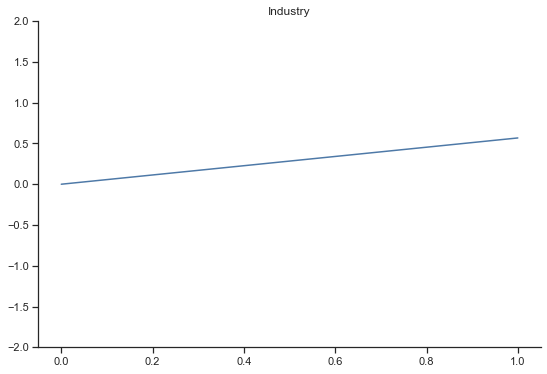

In [24]:
for j, term in enumerate(gam.terms):
    
    if term.isintercept:
        continue

    XX = gam.generate_X_grid(term=j)
    pdep, confi = gam.partial_dependence(term=j, X=XX, width=0.95)

    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    
    if j <= 1: # the reason for this if statement that the CIs don't look right for the linear terms
        plt.plot(XX[:, term.feature], confi, c='black', ls='--', alpha=0.5)
    
    plt.ylim(-2, 2)
        
    plt.title(predictors[j])
    sns.despine()
    plt.show()

# 5. Explainable boosting machine

An explainable boosting machine (EBM) fits a generalised additive model with interactions (sometimes referred to as a GA2M model) using trees as basis functions. We will discuss trees and boosting in the next two weeks, but EBM fits best with the present topic because other tree-based methods depart substantially from generalised additive modelling. 

We use the [Interpret ML](https://interpret.ml/) package.  

Note the following:

* Our goal here is to simply to show you how to use the method, as the training set is too small for it. I encourage you to apply it to the assignment, as it will allow your to make early progress on both the machine learning and data mining tasks.

* As always, you should to optimise the hyperparameters to get the best results. We will use the default values today (which work ok) and go back to this issue later after we study boosting.

In [64]:
# This takes more than a few seconds to run
from interpret.glassbox import ExplainableBoostingRegressor

# The interactions option set the number of interaction effects present in the model
# EBM detects the most useful ones to fit

ebm = ExplainableBoostingRegressor(interactions=5, random_state=1)
ebm.fit(X_train, y_train)

ExplainableBoostingRegressor(feature_names=['Acq_Expense', 'Ret_Expense',
                                            'First_Purchase', 'Revenue',
                                            'Employees', 'Frequency',
                                            'Crossbuy', 'Industry',
                                            'Ret_Expense x Revenue',
                                            'Acq_Expense x Ret_Expense',
                                            'Ret_Expense x Crossbuy',
                                            'Ret_Expense x Frequency',
                                            'Revenue x Frequency'],
                             feature_types=['continuous', 'continuous',
                                            'continuous', 'continuous',
                                            'continuous', 'continuous',
                                            'continuous', 'categorical',
                                            'interaction', 'interaction',
 

As the name suggests, EBM is designed for interpretability. Interpret ML provides tools for global and local interpretation. 

The global interpretation visualiser includes feature importance, partial dependence and interaction plots. The PDPs don't look so good, therefore I suggest that you try to code your own if you use this method. 

EBM is a useful for discovering relevant interaction effects.  

In [65]:
from interpret import set_visualize_provider
from interpret.provider import InlineProvider
set_visualize_provider(InlineProvider())

from interpret import show

ebm_global = ebm.explain_global()
show(ebm_global)

The local interpretation visualiser shows each feature's contribution to the prediction.

In [66]:
# Generate local explanations for the first five validation cases
ebm_local = ebm.explain_local(X_valid.iloc[:5, :], y_valid[:5])

# This part is a hack to remove the intercept from the plots (try without to see the difference)
for explanation in ebm_local._internal_obj['specific']:
    del explanation['extra']

show(ebm_local)

Here's an interesting video about EBM (just note that it's an exaggeration to say that you should abandon other methods). 

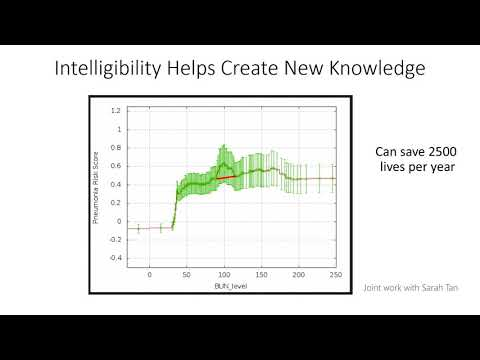

In [31]:
from IPython.display import YouTubeVideo

YouTubeVideo('MREiHgHgl0k', width=560, height=315)

# 7. Model selection

The validation metrics suggest that we get an substantial improvement in performance by using a GAM instead of a linear regression.

Ideally, and especially because there are not many observations, it's better to use (repeated) k-fold cross-validation to compare models, with nested CV for hyperparameter optimisation.  We used a validation set here for simplicity. 

In [69]:
ols = LinearRegression()
ols.fit(X_train, y_train)

from sklearn.metrics import mean_squared_error, r2_score,  mean_absolute_error

# Initialise table
columns=['RMSE', 'R-Squared', 'MAE']
rows=['OLS', 'GAM', 'EBM']
results =pd.DataFrame(0.0, columns=columns, index=rows)

# List algorithms
methods = [ols, gam, ebm] 

# Computer test predictions and metrics
for i, method in enumerate(methods):
    
    y_pred = method.predict(X_valid)
    
    results.iloc[i, 0] = np.sqrt(mean_squared_error(y_valid, y_pred))
    results.iloc[i, 1] = r2_score(y_valid, y_pred)
    results.iloc[i, 2] = mean_absolute_error(y_valid, y_pred)

results.round(3)

,RMSE,R-Squared,MAE
OLS,0.539,0.661,0.415
GAM,0.440,0.774,0.313
EBM,0.523,0.681,0.391


https://i.stack.imgur.com/pDWH5.png

# Cubic Spline vs Natural Cubic Spline

A cubic spline and natural cubic spline are both a $C^2$ function, meaning that they both have a continouos 2nd derivative. However, a natural cubic spline differes from a cubic spline by how it treates the boundaries. It is best explained by an example.

Suppose we wanted to create a cubic spline with 2 knots, on a variable $0 < x < 3$. What this means is that we are going to create the function

$$F(x)=\begin{cases} 
C_1(x) = a_1 + b_1x +c_1x^2+d_1x^3\quad &\textrm{for }\ 0 < x < 1\\
C_2(x) = a_2 + b_2x +c_2x^2+d_2x^3\quad &\textrm{for }\ 1 < x < 2\\
C_3(x) = a_3 + b_3x +c_3x^2+d_3x^3\quad &\textrm{for }\ 2 < x < 3\\
\end{cases}
$$

In otherwords, using a cubic spline with 2 knots, we are going to fit a cubic polynomial in 3 different regions. 

BUT, a cubic spline requires 3 things to be met

1. Continuity at boundaries: $C_1(1) = C_2(1)$; $C_2(2) = C_3(2)$ 
2. Continuity of 1st derivative at boundaries: $C_1^{'}(1) = C_2^{'}(1)$; $C_2^{'}(2) = C_3^{'}(2)$ 
3. Continuity of 2nd derivative at boundaries: $C_1^{''}(1) = C_2^{''}(1)$; $C_2^{''}(2) = C_3^{''}(2)$ 

In otherwords, 
1. A cubic spline requires the functions and their 1st and 2nd derivatives to be equal at the boundaries. Or
2. We require that the value, 1st derivative, and 2nd derivative at the end of $C_1$ to equal the value, 1st derivative and 2nd derivative at the beginning of $C_2$


A **natural cubic spline** is then a cubic spline with the added assumption that $C_1^{''}(0) = 0$ and $C_3^{''}(3)=0$. That is it requires the second derivative at the boundaries of $x$ ($0 < x < 3$) to be equal to zero.


### General Cubic Spline
More generally then, assuming the boundary is $a < x < b$ (note the boundaries is usaully the minimum and maximum of the dataset), then a cubic spline of degree $K$ is

$$F(x)=\begin{cases} 
C_1(x) = a_1 + b_1x +c_1x^2+d_1x^3\quad &\textrm{for }\ a < x < \xi_1\\
C_2(x) = a_2 + b_2x +c_2x^2+d_2x^3\quad &\textrm{for }\ \xi_1 < x < \xi_2\\
C_3(x) = a_3 + b_3x +c_3x^2+d_3x^3\quad &\textrm{for }\ \xi_2 < x < \xi_3\\
\cdots \\
C_K(x) = a_k + b_kx + c_kx^2+d_kx^3\quad &\textrm{for }\ \xi_{K-1} < x < b\\
\end{cases}
$$

with 
1. Continuity at boundaries: $C_i(\xi_i)=C_{i+1}(\xi_i)$. Note that $x_i$ is the end for the $C_i$ function, but the beginning of the $C_{i+1}$ function.
2. Continuity of 1st derivatives at boundaries: $C_i^{'}(\xi_i)=C_{i+1}^{'}(\xi_i)$
2. Continuity of 2nd derivatives at boundaries: $C_i^{''}(\xi_i)=C_{i+1}^{''}(\xi_i)$

### General Natural Cubic Spline
A natural cubic spline will then assume everything above, with the new assumption that

$$C_1^{''}(a)=0\qquad C_K^{''}(b)=0$$

$$f_1(x_1)=\beta_1 x_1$$

### GAMs!

So GAMs are very simple in idea. 

If we think back to linear regression, we make the model be 
$$\large Y = \beta_0 + \beta_1x_1 + \beta_2x_2 + \cdots + \beta_px_p$$

But, in GAMs, instead of each predictor having their own coefficient, we instead assume that each predictor has their own function
$$\large Y = \alpha_0 + f_1(x_1) + f_2(x_2) + \cdots + f_p(x_p)$$

### How To Fit a GAM
Of course, the question now is how do you choose and fit the functions $f_1, f_2, f_3, ...$

### GAM & BackFitting
Suppose we had $n$ datapoints and 3 predictors, $X_1,X_2,X_3$. The aim of backfitting is to find the corresponding functions $\hat{f}_1,\hat{f}_2,\hat{f}_3$.

To do that, we start of with a random guess of these functions. Doesn't really matter what you guess them as, but we'll just start of with $\hat{f}_1 = 0,\hat{f}_2 = 0,\hat{f}_3 = 0$. Note that one could of just as easily started of with these functions a linear regression functions.

First, we will fix $\hat{\alpha}$ as the mean of the data,
$$\hat{\alpha} = \frac{1}{n}\sum_{i=1}^nY_i$$

Now to find $\hat{f}_1$, we actually fit $\hat{f}_1$ according to the partial-residuals
$$e_1 = Y - \left[\hat{\alpha} + \hat{f}_2(X_2) + \hat{f}_3(X_3)\right]$$
Then $\hat{f}_2$ is fitted according to the new partial-residuals
$$e_2 = Y - \left[\hat{\alpha} + \hat{f}_1(X_1) + \hat{f}_3(X_3)\right]$$
Finally $\hat{f}_3$ is fitted according to the new partial-residuals
$$e_3 = Y - \left[\hat{\alpha} + \hat{f}_1(X_1) + \hat{f}_2(X_2)\right]$$

The total residual is then calculated
$$\mathcal{E} = Y - \left[\hat{\alpha} + \hat{f}_1(X_1) + \hat{f}_2(X_2)+ \hat{f}_3(X_3)\right]$$
We continue this process until the total residual, $\mathcal{E}$, fits some stopping criteron.

https://en.wikipedia.org/wiki/Backfitting_algorithm
